In [1]:
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
CHANNEL = "A-3"

In [3]:
class Channel:
    def __init__(self, chan_id):
        self.id = chan_id
        self.train = None
        self.test = None
        self.l_s = 250
        self.n_predictions = 10
        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.y_test = None
        self.y_hat = None

    def shape_data(self, arr, training=True):
        data = []
        for i in range(len(arr) - self.l_s - self.n_predictions):
            data.append(arr[i: i + self.l_s + self.n_predictions])
            
        data = np.array(data)

        if training:
            np.random.shuffle(data)
            self.X_train = data[:, :-self.n_predictions, :]
            self.y_train = data[:, -self.n_predictions:, 0]
        else:
            self.X_test = data[:, :-self.n_predictions, :]
            self.y_test = data[:, -self.n_predictions:, 0]

    def load_data(self):
        try:
            self.train = np.load(os.path.join("data", "train", "{}.npy".format(self.id)))
            self.test = np.load(os.path.join("data", "test", "{}.npy".format(self.id)))
        except FileNotFoundError as e:
            print(e)

        self.shape_data(self.train)
        self.shape_data(self.test, training=False)

In [4]:
new_channel = Channel(CHANNEL)
new_channel.load_data()

In [5]:
new_channel.X_train.shape[2]

25

In [6]:
new_channel.test.shape

(8205, 25)

In [7]:
new_channel.test.shape
new_channel.X_test.shape
new_channel.X_test.shape

(7945, 250, 25)

In [8]:
new_channel.train

array([[0.11308108, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.11308108, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.3336605 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.76415679, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.76415679, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.76415679, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [9]:
from keras_core.models import Sequential, load_model
from keras_core.callbacks import History, EarlyStopping
from keras_core.layers import Dense, Activation, Dropout, LSTM

class Model:
    def __init__(self, channel):
        self.chan_id = channel.id
        self.y_hat = np.array([])
        self.model = None
        self.train_new(channel)
        

    def train_new(self, channel):
        cbs = [History(), EarlyStopping(monitor='val_loss',
                                        patience=10,
                                        min_delta=0.0003,
                                        verbose=0)]

        self.model = Sequential()

        self.model.add(LSTM(
            80,
            input_shape=(None, channel.X_train.shape[2]),
            return_sequences=True))
        self.model.add(Dropout(0.3))

        self.model.add(LSTM(
            80,
            return_sequences=False))
        self.model.add(Dropout(0.3))

        self.model.add(Dense(
            channel.n_predictions))
        self.model.add(Activation('linear'))

        self.model.compile(loss='mse',
                           optimizer='adam')

        self.model.fit(channel.X_train,
                       channel.y_train,
                       batch_size=64,
                       epochs=35,
                       validation_split=0.2,
                       callbacks=cbs,
                       verbose=True)
        
    def aggregate_predictions(self, y_hat_batch, method='first'):
        agg_y_hat_batch = np.array([])

        for t in range(len(y_hat_batch)):

            start_idx = t - 10
            start_idx = start_idx if start_idx >= 0 else 0

            # predictions pertaining to a specific timestep lie along diagonal
            y_hat_t = np.flipud(y_hat_batch[start_idx:t+1]).diagonal()

            if method == 'first':
                agg_y_hat_batch = np.append(agg_y_hat_batch, [y_hat_t[0]])
            elif method == 'mean':
                agg_y_hat_batch = np.append(agg_y_hat_batch, np.mean(y_hat_t))

        agg_y_hat_batch = agg_y_hat_batch.reshape(len(agg_y_hat_batch), 1)
        self.y_hat = np.append(self.y_hat, agg_y_hat_batch)
              
    def batch_predict(self, channel):
        num_batches = int((channel.y_test.shape[0] - 250)
                          / 70)

        for i in range(0, num_batches + 1):
            prior_idx = i * 70
            idx = (i + 1) * 70

            if i + 1 == num_batches + 1:
                idx = channel.y_test.shape[0]

            X_test_batch = channel.X_test[prior_idx:idx]
            y_hat_batch = self.model.predict(X_test_batch)
            self.aggregate_predictions(y_hat_batch)

        self.y_hat = np.reshape(self.y_hat, (self.y_hat.size,))

        channel.y_hat = self.y_hat

        return channel


Using TensorFlow backend


2024-03-10 17:26:12.345101: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-10 17:26:12.402136: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-10 17:26:12.908378: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [10]:
model = Model(new_channel)

2024-03-10 17:26:13.619869: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-10 17:26:13.701997: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-10 17:26:13.702040: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-10 17:26:13.705600: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-10 17:26:13.705686: I tensorflow/compile

Epoch 1/35


/home/stoakman/anaconda3/envs/tf/lib/python3.9/site-packages/keras_core/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 6/31 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2190     

2024-03-10 17:26:15.515045: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2024-03-10 17:26:15.554393: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.1703 - val_loss: 0.0372
Epoch 2/35
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0378 - val_loss: 0.0335
Epoch 3/35
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0343 - val_loss: 0.0307
Epoch 4/35
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0312 - val_loss: 0.0315
Epoch 5/35
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0324 - val_loss: 0.0311
Epoch 6/35
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0307 - val_loss: 0.0296
Epoch 7/35
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0284 - val_loss: 0.0290
Epoch 8/35
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0322 - val_loss: 0.0285
Epoch 9/35
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0267 - val_loss: 0.0300
Epoch 10/35
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0274 - val_loss: 0.0282
Epoch 11/35
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0266 - val_loss: 0.0269
Epoch 12/35
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0256 - val_l

In [11]:
model.batch_predict(new_channel)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━

In [12]:
new_channel.y_hat.shape

(7945,)

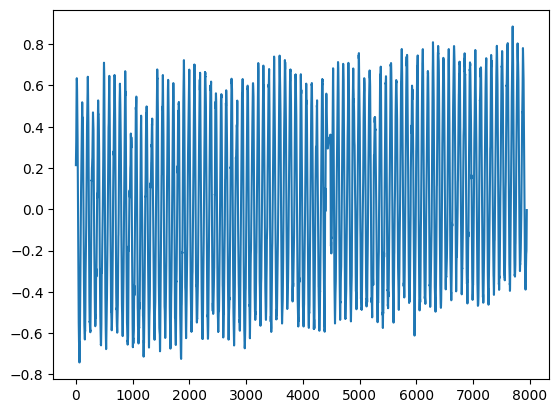

In [13]:
plt.plot(new_channel.y_hat)

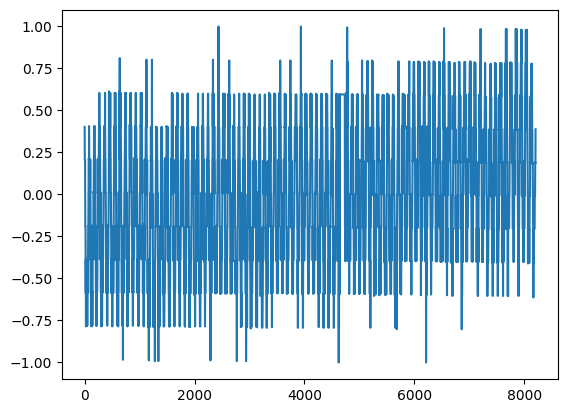

In [14]:
plt.plot(new_channel.test[:, 0])

In [15]:
class Plotter:
    def __init__(self, channel):
        self.channel = channel

    def plot_predictions(self, plot_real_data=True):
        if plot_real_data:
            plt.plot(self.channel.y_test[:, 0])
        else:
            plt.plot(self.channel.y_hat)

        anomalies = pd.read_csv("data/labeled_anomalies.csv")
        anomalies = anomalies[anomalies["chan_id"] == self.channel.id]
        anomalies_plot = anomalies['anomaly_sequences']
        anomalies_plot = eval(anomalies_plot.iloc[0])

        for rect in anomalies_plot:
            plt.axvspan(rect[0], rect[1], alpha=0.3, color='red')
        plt.show()
        
    
    def plot_custom_range_predictions(self, start, end, plot_real_data=True):
        if plot_real_data:
            plt.plot([i for i in range(start, end)], self.channel.y_test[:, 0][start:end])
        else:
             plt.plot([i for i in range(start, end)], self.channel.y_hat[start:end])

        anomalies = pd.read_csv("data/labeled_anomalies.csv")
        anomalies = anomalies[anomalies["chan_id"] == self.channel.id]
        anomalies_plot = anomalies['anomaly_sequences']
        anomalies_plot = eval(anomalies_plot.iloc[0])

        for rect in anomalies_plot:
            plt.axvspan(rect[0], rect[1], alpha=0.3, color='red')
        plt.show()

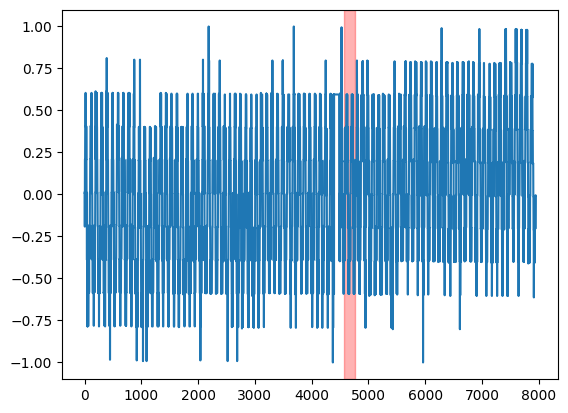

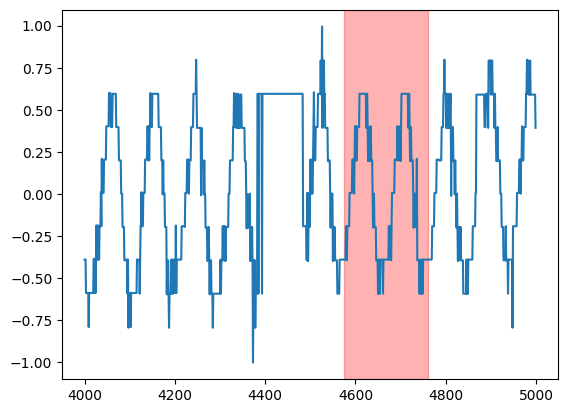

In [16]:
plotter = Plotter(new_channel)
plotter.plot_predictions()
plotter.plot_custom_range_predictions(4000, 5000)

In [17]:
error = np.abs(new_channel.y_test[:, 0] - new_channel.y_hat)
normalized = np.mean(error / np.ptp(new_channel.y_test))
normalized, error

(0.05123371153770057,
 array([0.20276866, 0.21774188, 0.23126209, ..., 0.07114939, 0.0325466 ,
        0.00297584]))

In [18]:
e_s = pd.DataFrame(error).ewm(span=105).mean().values.flatten()
e_s

array([0.20276866, 0.21032657, 0.21743842, ..., 0.07325265, 0.07248461,
       0.07117312])

In [24]:
epsilon = [np.average(e_s) + i*np.std(e_s) for i in range(2, 11)]
epsilon_argmax = np.argmax(epsilon)
epsilon_argmax

8

In [28]:
# plt.plot(e_s)

8